In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [13]:
# 整合数据集
def load_images_from_folder(root_folder):
    image_data = {}

    for dirpath, dirnames, filenames in os.walk(root_folder):
        for filename in filenames:
            # 检查文件是否是图片文件（根据文件扩展名）
            if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif', '.tiff')):
                # 提取分类标签（文件名中"_"前的部分）
                label = filename.split('_')[0]

                # 读取图片
                img_path = os.path.join(dirpath, filename)
                try:
                    image = cv2.imread(img_path, cv2.IMREAD_COLOR)
                    if image is not None:
                        # 将图片转换为numpy数组，并存储到相应分类的列表中
                        if label not in image_data:
                            image_data[label] = []
                        image_data[label].append(image)
                    else:
                        print(f"Failed to read image: {img_path}")
                except Exception as e:
                    print(f"Error processing {img_path}: {e}")

    return image_data

def save_images_to_npy(image_data, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for label, images in image_data.items():
        npy_file_path = os.path.join(output_folder, f"{label}.npy")
        np.save(npy_file_path, np.array(images))
        print(f"Saved {len(images)} images to {npy_file_path}")

# 指定根文件夹路径和输出文件夹路径
root_folder = r'D:\Python_code\DATA'
output_folder = r'D:\Python_code\Output'

# 读取图片并分类
image_data = load_images_from_folder(root_folder)

# 将分类后的图片保存为npy文件
save_images_to_npy(image_data, output_folder)

Saved 2840 images to D:\Python_code\Output\add.npy
Saved 2629 images to D:\Python_code\Output\divide.npy
Saved 2775 images to D:\Python_code\Output\eight.npy
Saved 2827 images to D:\Python_code\Output\five.npy
Saved 3180 images to D:\Python_code\Output\four.npy
Saved 3160 images to D:\Python_code\Output\multiply.npy
Saved 3212 images to D:\Python_code\Output\nine.npy
Saved 3631 images to D:\Python_code\Output\one.npy
Saved 3246 images to D:\Python_code\Output\seven.npy
Saved 2984 images to D:\Python_code\Output\six.npy
Saved 3452 images to D:\Python_code\Output\subtract.npy
Saved 2586 images to D:\Python_code\Output\three.npy
Saved 3828 images to D:\Python_code\Output\two.npy
Saved 2399 images to D:\Python_code\Output\zero.npy


In [10]:
# 文件夹路径
data_path = 'npys'

# 读取数据
labels = [
    'zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine',
    'add', 'subtract', 'multiply', 'divide'
]
x_train = []
y_train = []

for idx, label in enumerate(labels):
    data = np.load(os.path.join(data_path, f'{label}.npy'))
    x_train.append(data)
    y_train.append(np.full(len(data), idx))

x_train = np.concatenate(x_train, axis=0)
y_train = np.concatenate(y_train, axis=0)

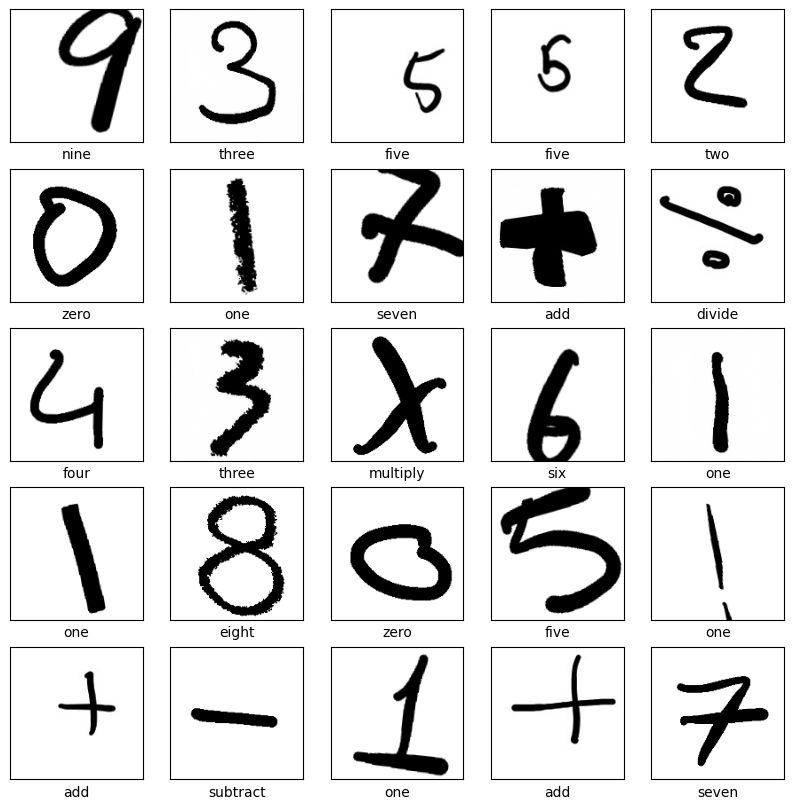

In [11]:
# 打乱数据
indices = np.arange(x_train.shape[0])
np.random.shuffle(indices)
x_train = x_train[indices]
y_train = y_train[indices]

# 将数据分为训练集和测试集
split_idx = int(0.8 * x_train.shape[0])
x_test = x_train[split_idx:]
y_test = y_train[split_idx:]
x_train = x_train[:split_idx]
y_train = y_train[:split_idx]

# 展示数据集
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i])
    plt.xlabel(labels[y_train[i]])
plt.show()

In [12]:
# 图像数据归一化
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# 调整数据形状，如果图像是150x150 RGB图像
# 确保图像数据形状为 (samples, 150, 150, 3)
if x_train.shape[-1] != 3:
    x_train = x_train.reshape(x_train.shape[0], 150, 150, 3)
    x_test = x_test.reshape(x_test.shape[0], 150, 150, 3)

# 将标签向量转换为二值矩阵
num_classes = 14  # 图像数据有14个实际标签类别
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

# 创建模型
model = Sequential()

# 图像输入形状(150, 150, 3) 对应(image_height, image_width, color_channels)
model.add(Conv2D(32, (3, 3), padding='same', input_shape=(150, 150, 3)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 3 维展平为 1 维，输入全连接层
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# 编译模型
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [13]:
# 训练模型
batch_size = 32
epochs = 10

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test, y_test))

# 保存模型
model.save('CNN_result.h5')

Epoch 1/10
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 358s 332ms/step - accuracy: 0.6530 - loss: 1.2670 - val_accuracy: 0.9216 - val_loss: 0.2641
Epoch 2/10
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 351s 329ms/step - accuracy: 0.9164 - loss: 0.2700 - val_accuracy: 0.9504 - val_loss: 0.1668
Epoch 3/10
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 350s 327ms/step - accuracy: 0.9454 - loss: 0.1700 - val_accuracy: 0.9592 - val_loss: 0.1379
Epoch 4/10
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 358s 335ms/step - accuracy: 0.9682 - loss: 0.0984 - val_accuracy: 0.9614 - val_loss: 0.1392
Epoch 5/10
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 389s 364ms/step - accuracy: 0.9780 - loss: 0.0706 - val_accuracy: 0.9593 - val_loss: 0.1635
Epoch 6/10
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 411s 384ms/step - accuracy: 0.9802 - loss: 0.0590 - val_accuracy: 0.9586 - val_loss: 0.1685
Epoch 7/10
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 412s 385ms/step - accuracy: 0.9864 - loss: 0.0409 - val_accuracy: 0.9676 - val_loss: 0.1231
Epoch 8/10
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 412s 385ms/step - ac